In [1]:
import sys

sys.path.append("../")

from src.common_functions import *
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss


# 1. Load data, prep & train test split

In [3]:
df = pd.read_csv("../datasets/churn/fin_churn.csv" )
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
RAW_DATA_PATH = "../datasets/churn/fin_churn.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
num_rows = len(df)
print(f'The dataset has {num_rows} rows.')

The dataset has 10000 rows.


In [6]:
df.exited.value_counts()/df.shape[0]*100

exited
0    79.63
1    20.37
Name: count, dtype: float64

In [7]:
70.63/20.37

3.467353951890034

In [8]:
20.37/70.63

0.28840436075322107

In [9]:
df.isna().any()

row_number          False
customer_id         False
surname             False
credit_score        False
geography           False
gender              False
age                 False
tenure              False
balance             False
num_of_products     False
has_cr_card         False
is_active_member    False
estimated_salary    False
exited              False
dtype: bool

In [10]:
y = "exited"

# some generic cleaning

COLUMNS_TO_DROP = ["customer_id", "surname"]
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [48]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': [6,8,10,12],
    'under__sampling_strategy': [0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose=1)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 192 candidates, totalling 960 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^

Best score: 0.7727851027149888
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 12, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['geography', 'gender'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=12)),
                ('logistic', LogisticRegression(C=100))])

In [49]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

Op de k-de fold als test set over alle k-folds de mean van test-metric = "roc_auc"

In [50]:
COLUMNS = ["under__sampling_strategy", "over__sampling_strategy", "pca__n_components", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS].sort_values(by=COLUMNS)

,under__sampling_strategy,over__sampling_strategy,pca__n_components,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,0.3,0.5,6,1,l2,0.696016,0.024889
48,0.3,0.5,6,10,l2,0.701800,0.016897
96,0.3,0.5,6,100,l2,0.688353,0.030496
144,0.3,0.5,6,1000,l2,0.700335,0.014341
4,0.3,0.5,8,1,l2,0.754289,0.008083
...,...,...,...,...,...,...,...
186,0.7,1.0,10,1000,l2,0.765532,0.006412
46,0.7,1.0,12,1,l2,0.770880,0.008610
94,0.7,1.0,12,10,l2,0.770576,0.006833
142,0.7,1.0,12,100,l2,0.772785,0.007519


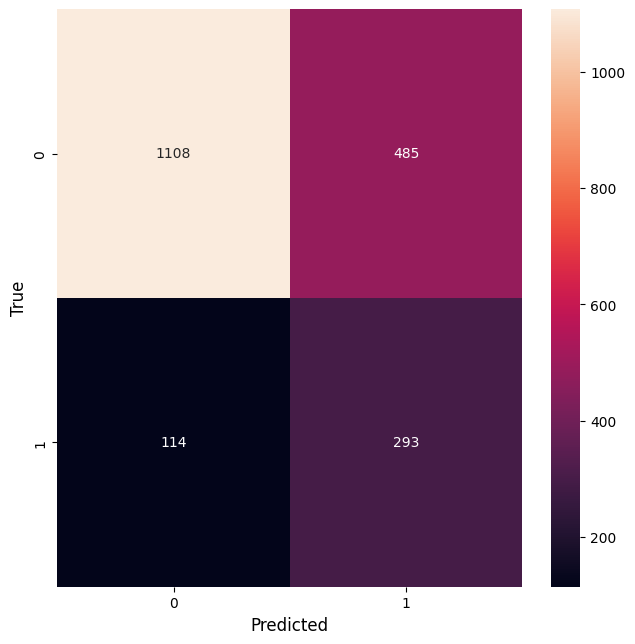

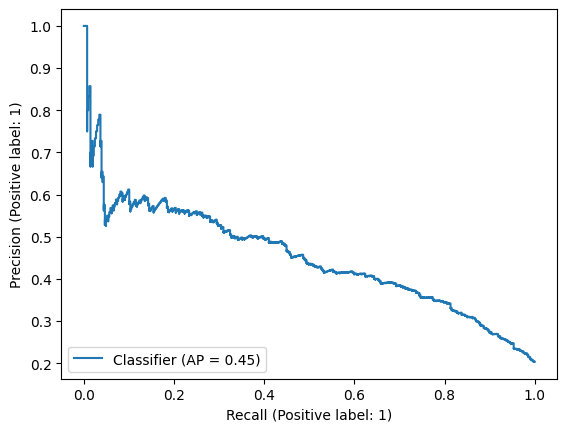

In [51]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [11]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [53]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [14, 20, 25, 30, 35, 50, 65],
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

xgb = XGBClassifier()

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized= True)
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.8349996629137735
Best parameters: {'xgb__subsample': 0.8, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 1, 'xgb__max_depth': 3, 'xgb__gamma': 1, 'xgb__colsample_bytree': 0.6, 'under__sampling_strategy': 0.5, 'pca__n_components': 14, 'over__sampling_strategy': 1}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['row_number', 'credit_score',
                                                   'age', 'tenure', 'balance',
                                                   'num_of_products',
                                                   'has_cr_card',
                                                   'is_active_member',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strate...
                               feature_types=None, gamma=1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [54]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

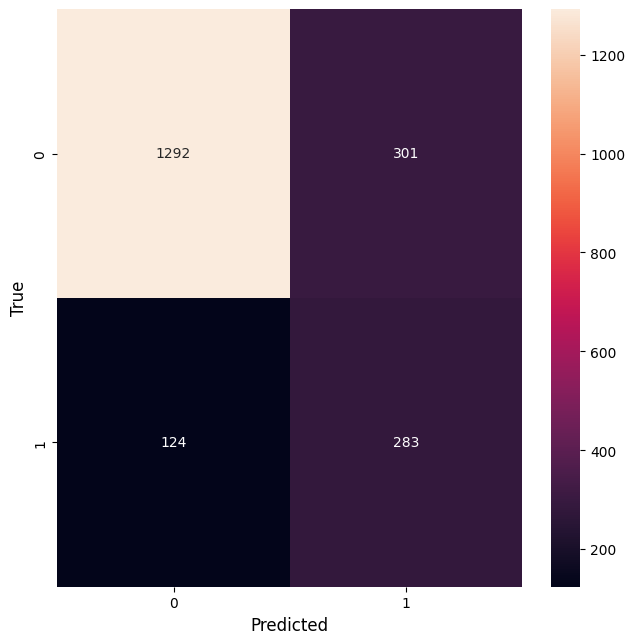

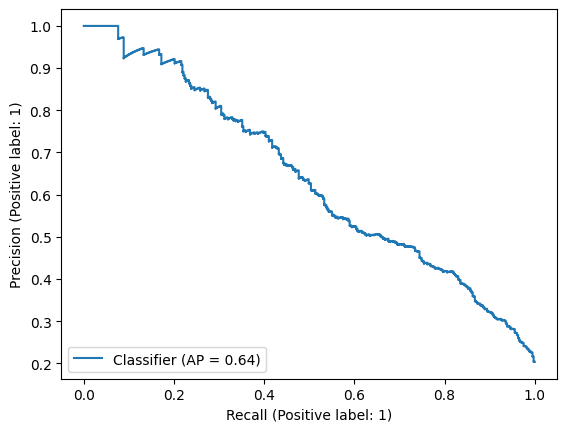

In [55]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

In [12]:
MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

# cost evaluation metrics

In [13]:
test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["balance"]*test_predictions_log["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_log['A'] = scaler.fit_transform(test_predictions_log['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 706.
 total cost/loss average :  0.3528633226828398


In [14]:
print(test_predictions_log[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.000000            0
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       1.197232            1
9089       0  0.308224       0.000000            0
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            0
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.719987            1
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.804297            1
2381       1  0.630841       0.000000            1
2112       0  0.000000       0.000000            0
2025       0  0.000000       0.000000            0
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.000000            0
4250       0  0.327531       0.

In [15]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["balance"]*test_predictions_xgb["credit_score"]).to_frame())[:, 0]
scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
test_predictions_xgb['A'] = scaler.fit_transform(test_predictions_xgb['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['exited', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 700.
 total cost/loss average :  0.3499183770710998


In [16]:
print(test_predictions_xgb[['exited', "A", 'instance_cost', 'y_predicted']].iloc[31:60])
print(test[y])

      exited         A  instance_cost  y_predicted
1690       0  0.208530       0.000000            0
6514       0  0.000000       0.000000            0
5741       0  0.479974       0.000000            0
4478       0  0.000000       0.000000            0
3729       0  0.000000       0.000000            0
6626       0  0.598616       0.000000            0
9089       0  0.308224       0.000000            0
1868       0  0.366322       0.000000            0
6676       0  0.000000       0.000000            0
8241       0  0.000000       0.000000            0
9441       0  0.359994       0.000000            0
9690       1  0.687904       8.254851            0
5032       0  0.402149       0.804297            1
2381       1  0.630841       0.000000            1
2112       0  0.000000       0.000000            0
2025       0  0.000000       0.000000            0
9118       0  0.000000       0.000000            0
1525       0  0.454388       0.000000            0
4250       0  0.327531       0.

# AMC metric

Decision Threshold: 0.01, Test cost/loss = 836.28
Decision Threshold: 0.02, Test cost/loss = 836.28
Decision Threshold: 0.03, Test cost/loss = 836.28
Decision Threshold: 0.04, Test cost/loss = 836.28
Decision Threshold: 0.05, Test cost/loss = 836.28
Decision Threshold: 0.06, Test cost/loss = 834.67
Decision Threshold: 0.07, Test cost/loss = 832.65
Decision Threshold: 0.08, Test cost/loss = 831.22
Decision Threshold: 0.09, Test cost/loss = 828.31
Decision Threshold: 0.10, Test cost/loss = 826.85
Decision Threshold: 0.11, Test cost/loss = 822.15
Decision Threshold: 0.12, Test cost/loss = 815.02
Decision Threshold: 0.13, Test cost/loss = 812.29
Decision Threshold: 0.14, Test cost/loss = 811.33
Decision Threshold: 0.15, Test cost/loss = 807.12
Decision Threshold: 0.16, Test cost/loss = 803.35
Decision Threshold: 0.17, Test cost/loss = 799.80
Decision Threshold: 0.18, Test cost/loss = 794.51
Decision Threshold: 0.19, Test cost/loss = 781.58
Decision Threshold: 0.20, Test cost/loss = 778.76


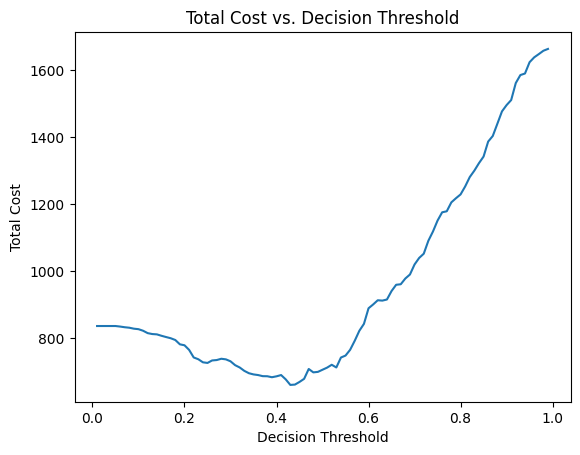

In [21]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log")

Decision Threshold: 0.01, Test cost/loss = 833.17
Decision Threshold: 0.02, Test cost/loss = 818.35
Decision Threshold: 0.03, Test cost/loss = 815.87
Decision Threshold: 0.04, Test cost/loss = 800.08
Decision Threshold: 0.05, Test cost/loss = 794.71
Decision Threshold: 0.06, Test cost/loss = 779.58
Decision Threshold: 0.07, Test cost/loss = 765.13
Decision Threshold: 0.08, Test cost/loss = 751.89
Decision Threshold: 0.09, Test cost/loss = 736.74
Decision Threshold: 0.10, Test cost/loss = 720.79
Decision Threshold: 0.11, Test cost/loss = 724.80
Decision Threshold: 0.12, Test cost/loss = 710.37
Decision Threshold: 0.13, Test cost/loss = 703.54
Decision Threshold: 0.14, Test cost/loss = 702.98
Decision Threshold: 0.15, Test cost/loss = 707.23
Decision Threshold: 0.16, Test cost/loss = 694.10
Decision Threshold: 0.17, Test cost/loss = 689.83
Decision Threshold: 0.18, Test cost/loss = 672.78
Decision Threshold: 0.19, Test cost/loss = 669.46
Decision Threshold: 0.20, Test cost/loss = 665.25


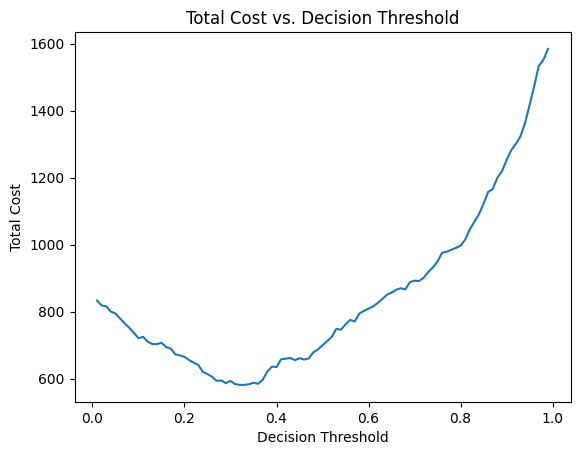

In [23]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb")

# E-AMC metric

In [25]:
test_predictions_log = add_eap_ep(train, test_predictions_log, y, best_pipeline_log_reg, cb_column, model_name="log", instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(train, test_predictions_xgb, y, best_pipeline_xgb, cb_column, model_name="xgb", instance_dependent_cost_type="churn")

/home/maarten/projects/personal/End-to-end-project---Customer-churn/notebooks/../src/common_functions.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
/home/maarten/projects/personal/End-to-end-project---Customer-churn/notebooks/../src/common_functions.py:309: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estimated_p_1*test_actual_label_0['FP']+estimated_p_0*test_actual_l

In [26]:
test_predictions_log

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.280975,0,7.215993,1.202666,0,0.337919,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,1,0,0.000000,0.000000,1,0.660168,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.321589,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.337583,0,4.258328,0.709721,0,0.239590,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.365230,0,5.134061,0.855677,0,0.312519,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,1,1,0.000000,0.000000,1,0.553489,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.262813,0,8.464146,1.410691,0,6.239655,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.565701,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.647063,0,4.556821,0.759470,0,1.608273,3.628369


In [27]:
test_predictions_xgb

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.401761,0,7.215993,1.202666,0,0.483184,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,0,0,0.000000,0.000000,0,0.121654,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.044372,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.048170,0,4.258328,0.709721,0,0.034188,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.244236,0,5.134061,0.855677,0,0.208987,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,1,1,0.000000,0.000000,1,0.554114,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.362564,0,8.464146,1.410691,0,5.395355,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.650903,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.811718,0,4.556821,0.759470,0,0.857967,3.628369


In [29]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

957.1795523601863
1497.296708062372
EAP :  0.4785897761800932
EP :  0.748648354031186


In [30]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

846.8085415601131
1497.296708062372
EAP :  0.42340427078005655
EP :  0.748648354031186


# emp and mp for non instance based 

In [67]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions['y_predicted_proba'], test_predictions["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1


In [68]:
test_predictions = test.copy(deep=True)
test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
test_predictions["churn_encoded"] = fit_le.transform(test_predictions["exited"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions["y_predicted_proba"], test_predictions["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


output(MP=4.628640999999999, MP_fraction=0.47350000000000003, EMP=4.769242166747453, EMP_fraction=0.4213615124513759)

In [69]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_xgb['y_predicted_proba'], test_predictions_xgb["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1


In [70]:
test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["exited"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_xgb["y_predicted_proba"], test_predictions_xgb["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)

C:\Users\stijn\AppData\Local\Temp\ipykernel_21144\2700567008.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.645139, MP_fraction=0.39749999999999996, EMP=5.727261184861413, EMP_fraction=0.3615217838156183)

# emp instance based


In [93]:
cb_column = 'cb'
test[cb_column]=(test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])

test['TN'] = 0
test['FN'] = 12 *(test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])
test['FP'] = 2* (test["order_amount_hike_fromlast_year"]* test['day_since_last_order'] * test['hour_spend_on_app'])
test['TP'] = 0

test = add_eap_ep(train, test, y, best_pipeline_log_reg, cb_column)

test_predictions_xgb = add_eap_ep(train, test, y, best_pipeline_xgb, cb_column)

KeyError: 'order_amount_hike_fromlast_year'

# mp instance based

# cost curves test

In [31]:
test_predictions_log

,row_number,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,y_predicted,churn_encoded,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
8167,8168,713,Germany,Female,24,7,147687.24,1,1,1,121592.50,0,0,0,0.601333,0.000000,0,0.280975,0,7.215993,1.202666,0,0.337919,0.245043
4747,4748,663,Spain,Male,64,6,0.00,2,0,1,15876.52,0,1,0,0.000000,0.000000,1,0.660168,0,0.000000,0.000000,0,0.000000,0.000000
2090,2091,667,Spain,Male,39,9,0.00,2,1,0,68873.80,0,0,0,0.000000,0.000000,0,0.321589,0,0.000000,0.000000,0,0.000000,0.000000
3298,3299,558,Germany,Male,25,10,111363.10,2,1,0,197264.35,0,0,0,0.354861,0.000000,0,0.337583,0,4.258328,0.709721,0,0.239590,0.144606
9485,9486,850,Spain,Male,37,4,88141.10,1,1,0,109659.12,0,0,0,0.427838,0.000000,0,0.365230,0,5.134061,0.855677,0,0.312519,0.174344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8379,8380,434,Spain,Male,55,6,0.00,1,0,1,73562.05,1,1,1,0.000000,0.000000,1,0.553489,0,0.000000,0.000000,0,0.000000,0.000000
7223,7224,799,Germany,Male,31,9,154586.92,1,0,1,88604.89,1,0,1,0.705345,8.464146,0,0.262813,0,8.464146,1.410691,0,6.239655,6.739576
1046,1047,807,Spain,Female,42,1,0.00,1,1,0,16500.66,1,1,1,0.000000,0.000000,1,0.565701,0,0.000000,0.000000,0,0.000000,0.000000
1487,1488,710,Spain,Female,51,4,93656.95,1,0,1,141400.51,1,1,1,0.379735,4.556821,1,0.647063,0,4.556821,0.759470,0,1.608273,3.628369


In [92]:
# cb_column = 'A'
model_name = 'log'
y_predicted_prob_col_name = f"y_predicted_proba_{model_name}"

# C(-|+)
cost_fn = 12* test_predictions_log[cb_column]
# C(+|-)
cost_fp = 2* test_predictions_log[cb_column]

# Ground truth
truth = test_predictions_log[y]
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log[y_predicted_prob_col_name]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, thresholds = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
# thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn) / (thresholds*cost_fn + (1-thresholds)*cost_fp)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

KeyError: 'order_amount_hike_fromlast_year'